# Berea Sandstone Simulation Using PoreSpy and OpenPNM

The example explains effective permeabilty calculations using PoreSpy and OpenPNM software. The simulation is performed on X-ray tomography image of [BereaSandstone](https://www.imperial.ac.uk/earth-science/research/research-groups/perm/research/pore-scale-modelling/micro-ct-images-and-networks/berea-sandstone/). The calculated effective permeablity value can compared with value report in [Dong et al](https://www.semanticscholar.org/paper/Pore-network-extraction-from-images.-Dong-Blunt/31fbb0362bd02e483c8b1f19f944f9bf15095a80).   

### Start by importing the necessary packages

In [1]:
import os
import imageio
import scipy as sp
import numpy as np
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import porespy as ps
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
np.random.seed(10)
%matplotlib inline

### Load BreaSandstone Image file

Give path to image file and load the image. Please note image should be binarized or in boolean format before performing next steps.

In [2]:
path = '../../_fixtures/ICL-Sandstone(Berea)/'
file_format = '.tif'
file_name = 'Berea'
file = file_name + file_format
fetch_file = os.path.join(path, file)
im = imageio.mimread(fetch_file)
im = ~np.array(im, dtype=bool)[:250, :250, :250]  # Make image a bit smaller

### Confirm image and check image porosity
Be patient, this might take ~30 seconds (depending on your CPU)

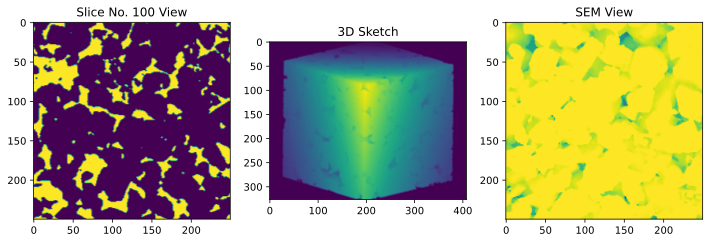

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(im[:, :, 100]);
ax[1].imshow(ps.visualization.show_3D(im));
ax[2].imshow(ps.visualization.sem(im));
ax[0].set_title("Slice No. 100 View");
ax[1].set_title("3D Sketch");
ax[2].set_title("SEM View");

In [4]:
print(ps.metrics.porosity(im))

0.204275328


### Extract pore network using SNOW algorithm in PoreSpy

The SNOW algorithm (an accronym for Sub-Network from an Oversegmented Watershed) was presented by [Gostick](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.96.023307). The algorithm was used to extract pore network from BereaSandstone image.

In [5]:
resolution = 5.345e-6
net = ps.networks.snow(im=im, voxel_size=resolution)

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  2761
Peaks after trimming saddle points:  1135
Peaks after trimming nearby peaks:  1135
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 1626/1626 [00:13<00:00, 120.15it/s]


### Import network in OpenPNM

The output from the SNOW algorithm above is a plain python dictionary containing all the extracted pore-scale data, but it is NOT yet an OpenPNM network. We need to create an empty network in OpenPNM, then populate it with the data from SNOW:

In [6]:
pn, geo = op.io.PoreSpy.import_data(net)

Now we can print the network to see how the transferred worked.

> Note to developers:  We need to ignore the output of the following cell since the number of pores differs depending on whether the code is run on a windows or linux machine.  

In [7]:
print(pn)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.GenericNetwork : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                    1626 / 1626 
2     throat.conns                                   2537 / 2537 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      1626      
2     pore.back                                     77        
3     pore.bottom                                   84        
4     pore.boundary                                 491       
5     pore.front                             

### Check network health

Remove isolated pores or cluster of pores from the network by checking it network health. Make sure ALL keys in network health functions have no value. 

In [8]:
h = pn.check_network_health()
op.topotools.trim(network=pn, pores=h['trim_pores'])
h = pn.check_network_health()
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
disconnected_clusters               []
isolated_pores                      []
trim_pores                          []
duplicate_throats                   []
bidirectional_throats               []
headless_throats                    []
looped_throats                      []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### Assign phase

In this example air is considered as fluid passing through porous channels. 

In [9]:
air = op.phases.Air(network=pn)

### Assign physics

In [10]:
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geo)

### Assign Algorithm and boundary conditions

Select stokes flow algorithm for simulation and assign dirichlet boundary conditions in top and bottom faces of the network.

In [11]:
perm = op.algorithms.StokesFlow(network=pn)
perm.setup(phase=air)
perm.set_value_BC(pores=pn.pores('top'), values=0)
perm.set_value_BC(pores=pn.pores('bottom'), values=101325)
perm.run()
air.update(perm.results())

### Calculate effective permeability

Caclulate effective permeablity using hagen poiseuille equation. Use cross section area and flow length manually from image dimension. 

In [12]:
resolution = 5.345e-6
Q = perm.rate(pores=pn.pores('bottom'), mode='group')[0]
A = (im.shape[0] * im.shape[1]) * resolution**2
L = im.shape[2] * resolution
mu = air['pore.viscosity'].max()
delta_P = 101325 - 0
K = Q * L * mu / (A * delta_P)

> Note to developers:  We need to ignore the output of the following cell since the results are slightly different on different platforms (windows vs linux)

In [13]:
print(f'The value of K is: {K/0.98e-12*1000:.2f} mD')

The value of K is: 1343.83 mD
